In [1]:
#must restart notebook kernel every time
import findspark

In [2]:
findspark.init('/home/linhle/spark-2.1.0-bin-hadoop2.7')

In [3]:
PORT = 7777 # could be any unused port
REFRESH_INTERVAL = 10 # seconds
TOP_X_MOST_FREQUENT = 5 # filter for this many tweets in desc frequency

In [4]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [5]:
sc = SparkContext()

In [6]:
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [7]:
socket_stream = ssc.socketTextStream("127.0.0.1", PORT)

In [8]:
lines = socket_stream.window( 20 )

In [9]:
from collections import namedtuple
fields = ("tag", "count")
Tweet = namedtuple('Tweet', fields)

In [10]:
words = lines.flatMap(lambda text: text.split(" "))
tags = words.filter(lambda word: word.lower().startswith("#"))
pairs = tags.map(lambda word: (word.lower(), 1))
wordCounts = pairs.reduceByKey(lambda a, b: a + b)
tweets = wordCounts.map(lambda wordCount: Tweet(wordCount[0], wordCount[1]))
(tweets
  .foreachRDD(lambda rdd: rdd.toDF().sort(desc("count")) # sorts Them in a DF
  .limit(TOP_X_MOST_FREQUENT).registerTempTable("tweets"))) # registers to a table.

In [11]:
# start TweetListener then start ssc
ssc.start()    

In [12]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# for display in jupyter notebook
%matplotlib inline 


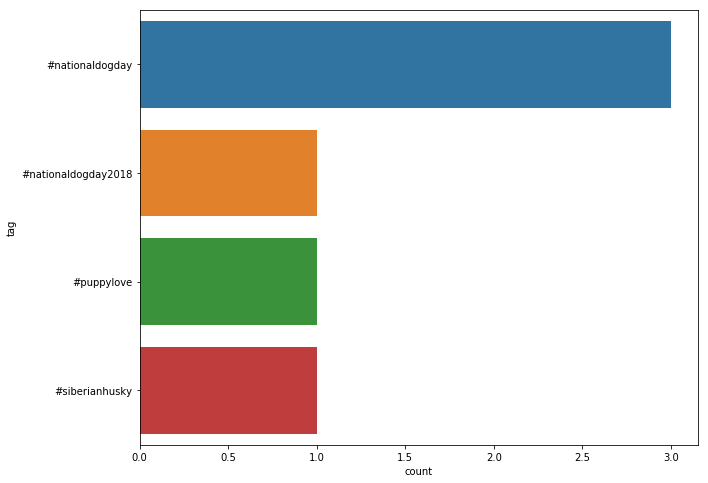

In [ ]:
while True:
    time.sleep(REFRESH_INTERVAL)
    top_tweets = sqlContext.sql('SELECT tag, count FROM tweets')
    top_tweets_df = top_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure(figsize = ( 10, 8 ))
    sns.barplot(x = "count", y = "tag", data = top_tweets_df)
    plt.show()

In [ ]:
ssc.stop()